In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
from scraper_utils import *
from kg_utils import *
from viz_utils import *

## Scrape Wikipedia pages, starting from a given page

In [3]:
root_page = 'Bayer'
wiki_data = wiki_scrape(root_page)
wiki_data.reset_index(drop=True, inplace=True)

Links Scraped: 100%|██████████| 530/530 [01:49<00:00,  4.85/s]


In [4]:
wiki_data

page  ...                                         categories
0                                Bayer  ...  [1863 establishments in Germany, Agriculture c...
1                                  DAX  ...  [All articles with dead external links, Articl...
2                                 E.ON  ...  [2000 establishments in Germany, All articles ...
3                            Munich Re  ...  [1880 establishments in Germany, Articles cont...
4                               Barmen  ...  [All accuracy disputes, All articles needing a...
..                                 ...  ...                                                ...
481                             Willow  ...  [All articles lacking reliable references, All...
482                       West Germany  ...  [1949 establishments in Germany, 1949 establis...
483                           Propoxur  ...  [Acetylcholinesterase inhibitors, All articles...
484                Erich von der Heyde  ...  [1900 births, 1984 deaths, German agronomists,...
485  Regulation of genetic engineering  ...  [Genetic engineering, Politics and technology,...

[486 rows x 4 columns]

## Build white/blacklists of page titles and categories which we will use to build Knowledge Graphs

In [5]:
# Pages from which we extract domain-specific whitelisted categories, in order to discard irrelevant pages
page_whitelist = ["Bayer", "Pharmaceutical industry"]

# Irrelevant pages which we know we want to ignore
page_blacklist = ["Auschwitz concentration camp", "Bayer 04 Leverkusen", "Monowitz concentration camp",
                  "TSV Bayer 04 Leverkusen", "KFC Uerdingen 05", ]

# Categories which we know are not relevant for the given domain
# These blacklisted categories are an irrelevant subset of categories from whitelisted pages
# All other categories from whitelisted pages are used to build the category whitelist
cat_blacklist = ["All articles", "Articles", "CS1", "Pages", "Portal", "Use dmy dates", 
                 "USA-centric", "Webarchive", "Wikipedia", "Wikidata", "Good articles", 
                 "Germany", "German", "Leverkusen", "Rhine", "factual verification", "RTT",
                 "Euro Stoxx 50", "Stock Exchange", "Holocaust", "changes to watched fields"] 

# Build category whitelist using pages whitelist and category blacklist
cat_whitelist = build_category_whitelist(wiki_data, page_whitelist, cat_blacklist)

In [6]:
cat_whitelist

{'Aspirin',
 'Bayer AG',
 'Genetic engineering and agriculture',
 'IG Farben',
 'Life sciences industry',
 'Manufacturing companies established in 1863',
 'Nanotechnology companies',
 'Orphan drug companies',
 'Pharmaceutical companies established in 1863',
 'Pharmaceutical industry',
 'Pharmacology',
 'Pharmacy'}

## Build/set other variables for KG construction

In [7]:
# List of domain-specific entities which Spacy tools may not recognize as Named entities or Nouns chunks
global_ents_list = [title.lower() for title in wiki_data.page]

In [8]:
subj_freq_thresh = 20  # Threshold for pruning infrequently occuring subjects from KG
obj_freq_thresh = 10  # Threshold for pruning infrequently occuring objects from KG

## Mine KG triplets from relevant/domain-specific pages

In [43]:
wiki_triplets = pd.DataFrame(columns=['subject', 'relation', 'object'])
for idx in range(len(wiki_data)-1):
    title = wiki_data.page[idx]
    text = wiki_data.text[idx]
    cats = wiki_data.categories[idx]
    
    # Determine page relevance/whether we want to use it in KG
    is_relevant = False
    if title not in page_blacklist:
        for cat in cats:
            # If any page category is in the whitelise, use it
            if cat in cat_whitelist:
                is_relevant = True
                break

    if is_relevant:
        print(title)
        # Extract S-R-O triplets
        triplets = extract_triplets(text, title, global_ents_list)
        # Merge duplicate subjects and extensions of the title
        triplets = merge_duplicate_subjs(triplets, title)
        wiki_triplets = wiki_triplets.append(triplets, ignore_index=True)

Bayer


100%|██████████| 348/348 [00:05<00:00, 65.17it/s]


Sterling Drug


100%|██████████| 41/41 [00:00<00:00, 53.18it/s]


Pre-clinical development


100%|██████████| 41/41 [00:00<00:00, 63.13it/s]


Fresenius (company)


100%|██████████| 78/78 [00:00<00:00, 86.71it/s]


Innovative Medicines Initiative


100%|██████████| 30/30 [00:00<00:00, 81.18it/s]


IG Farben Building


100%|██████████| 171/171 [00:02<00:00, 80.55it/s]


Pharmaceutical company


100%|██████████| 320/320 [00:04<00:00, 66.37it/s]


EFPIA


100%|██████████| 69/69 [00:00<00:00, 75.57it/s]


Biotechnology


100%|██████████| 180/180 [00:02<00:00, 60.67it/s]


Pharmaceutical companies


100%|██████████| 320/320 [00:04<00:00, 67.12it/s]


Bayer AG


100%|██████████| 348/348 [00:04<00:00, 74.90it/s]


Hoffmann-La Roche


100%|██████████| 196/196 [00:02<00:00, 80.06it/s]


Alka-Seltzer


100%|██████████| 92/92 [00:01<00:00, 59.47it/s]


Monsanto


100%|██████████| 459/459 [00:06<00:00, 76.44it/s]


Arthur Eichengrün


100%|██████████| 71/71 [00:01<00:00, 69.86it/s]


BASF


100%|██████████| 208/208 [00:02<00:00, 76.63it/s]


Genetically modified crops


100%|██████████| 406/406 [00:06<00:00, 61.96it/s]


Bayer Aspirin


100%|██████████| 348/348 [00:04<00:00, 69.93it/s]


IG Farben Trial


100%|██████████| 81/81 [00:01<00:00, 56.42it/s]


Sterling Winthrop


100%|██████████| 41/41 [00:00<00:00, 58.22it/s]


Agfa-Gevaert


100%|██████████| 258/258 [00:02<00:00, 94.36it/s] 


Miles Laboratories


100%|██████████| 23/23 [00:00<00:00, 68.31it/s]


List of life sciences


100%|██████████| 119/119 [00:01<00:00, 74.45it/s]


Aspirin


100%|██████████| 319/319 [00:04<00:00, 73.95it/s]


IG Farben


100%|██████████| 228/228 [00:03<00:00, 64.97it/s]


SmithKline Beecham


100%|██████████| 277/277 [00:04<00:00, 55.66it/s]


Life sciences


100%|██████████| 119/119 [00:01<00:00, 61.69it/s]


Cassella Farbwerke Mainkur Aktiengesellschaft


100%|██████████| 42/42 [00:00<00:00, 54.74it/s]


Pharmaceutical industry


100%|██████████| 320/320 [00:05<00:00, 60.53it/s]


Hoechst AG


100%|██████████| 42/42 [00:00<00:00, 86.04it/s]


ASML Holding


100%|██████████| 38/38 [00:00<00:00, 78.46it/s]


Plant Genetic Systems


100%|██████████| 28/28 [00:00<00:00, 79.01it/s]


Bayer


100%|██████████| 348/348 [00:04<00:00, 72.64it/s]


Felix Hoffmann


100%|██████████| 35/35 [00:00<00:00, 64.19it/s]


Merck & Co.


100%|██████████| 239/239 [00:03<00:00, 65.90it/s]


Merck & Co


100%|██████████| 239/239 [00:03<00:00, 63.88it/s]


Schering AG


100%|██████████| 30/30 [00:00<00:00, 49.09it/s]


Jenapharm


100%|██████████| 83/83 [00:01<00:00, 74.45it/s]


Roche Pharmaceuticals


100%|██████████| 196/196 [00:02<00:00, 78.98it/s]


Sanofi


100%|██████████| 186/186 [00:02<00:00, 64.10it/s]


Acetylsalicylic acid


100%|██████████| 319/319 [00:04<00:00, 72.26it/s]


In [44]:
wiki_triplets

subject  ...                   object
0                bayer  ...                   german
1                bayer  ...               leverkusen
2                bayer  ...                    seeds
3                bayer  ...                     euro
4       werner baumann  ...                      ceo
...                ...  ...                      ...
12042            fever  ...  blood clotting diseases
12043             cats  ...           metabolization
12044  acetylsalicylic  ...           metabolization
12045         products  ...           metabolization
12046  acetylsalicylic  ...           metabolization

[12047 rows x 3 columns]

In [45]:
wiki_triplets.describe()

subject relation object
count    12047    12047  12047
unique    2098     6093   3576
top      bayer       be  bayer
freq      1296      387    264

## Prune KG nodes using heuristics

In [46]:
wiki_triplets = prune_infreq_subjects(wiki_triplets, threshold=subj_freq_thresh)
wiki_triplets

subject  ...          object
0                bayer  ...          german
1                bayer  ...      leverkusen
2                bayer  ...           seeds
3                bayer  ...            euro
5                bayer  ...             ceo
...                ...  ...             ...
12034  acetylsalicylic  ...         aspirin
12038  acetylsalicylic  ...         aspirin
12041  acetylsalicylic  ...         aspirin
12044  acetylsalicylic  ...  metabolization
12046  acetylsalicylic  ...  metabolization

[7115 rows x 3 columns]

In [47]:
wiki_triplets.describe()

subject relation object
count     7115     7115   7115
unique      43     4229   2597
top      bayer       be  bayer
freq      1296      133    140

In [48]:
wiki_triplets = prune_infreq_objects(wiki_triplets, threshold=obj_freq_thresh)
wiki_triplets

subject  ...     object
0                bayer  ...     german
2                bayer  ...      seeds
6                bayer  ...    aspirin
10               bayer  ...  ig farben
11               bayer  ...  ig farben
...                ...  ...        ...
12017  acetylsalicylic  ...    aspirin
12020          aspirin  ...      bayer
12034  acetylsalicylic  ...    aspirin
12038  acetylsalicylic  ...    aspirin
12041  acetylsalicylic  ...    aspirin

[1800 rows x 3 columns]

In [49]:
wiki_triplets.describe()

subject relation object
count     1800     1800   1800
unique      43     1206     79
top      bayer       be  bayer
freq       497       23    140

In [50]:
wiki_triplets = prune_self_loops(wiki_triplets)
wiki_triplets

subject  ...     object
0                bayer  ...     german
2                bayer  ...      seeds
6                bayer  ...    aspirin
10               bayer  ...  ig farben
11               bayer  ...  ig farben
...                ...  ...        ...
12017  acetylsalicylic  ...    aspirin
12020          aspirin  ...      bayer
12034  acetylsalicylic  ...    aspirin
12038  acetylsalicylic  ...    aspirin
12041  acetylsalicylic  ...    aspirin

[1694 rows x 3 columns]

In [51]:
wiki_triplets.describe()

subject relation   object
count     1694     1694     1694
unique      43     1119       79
top      bayer       be  aspirin
freq       426       23      112

## Visualize KG

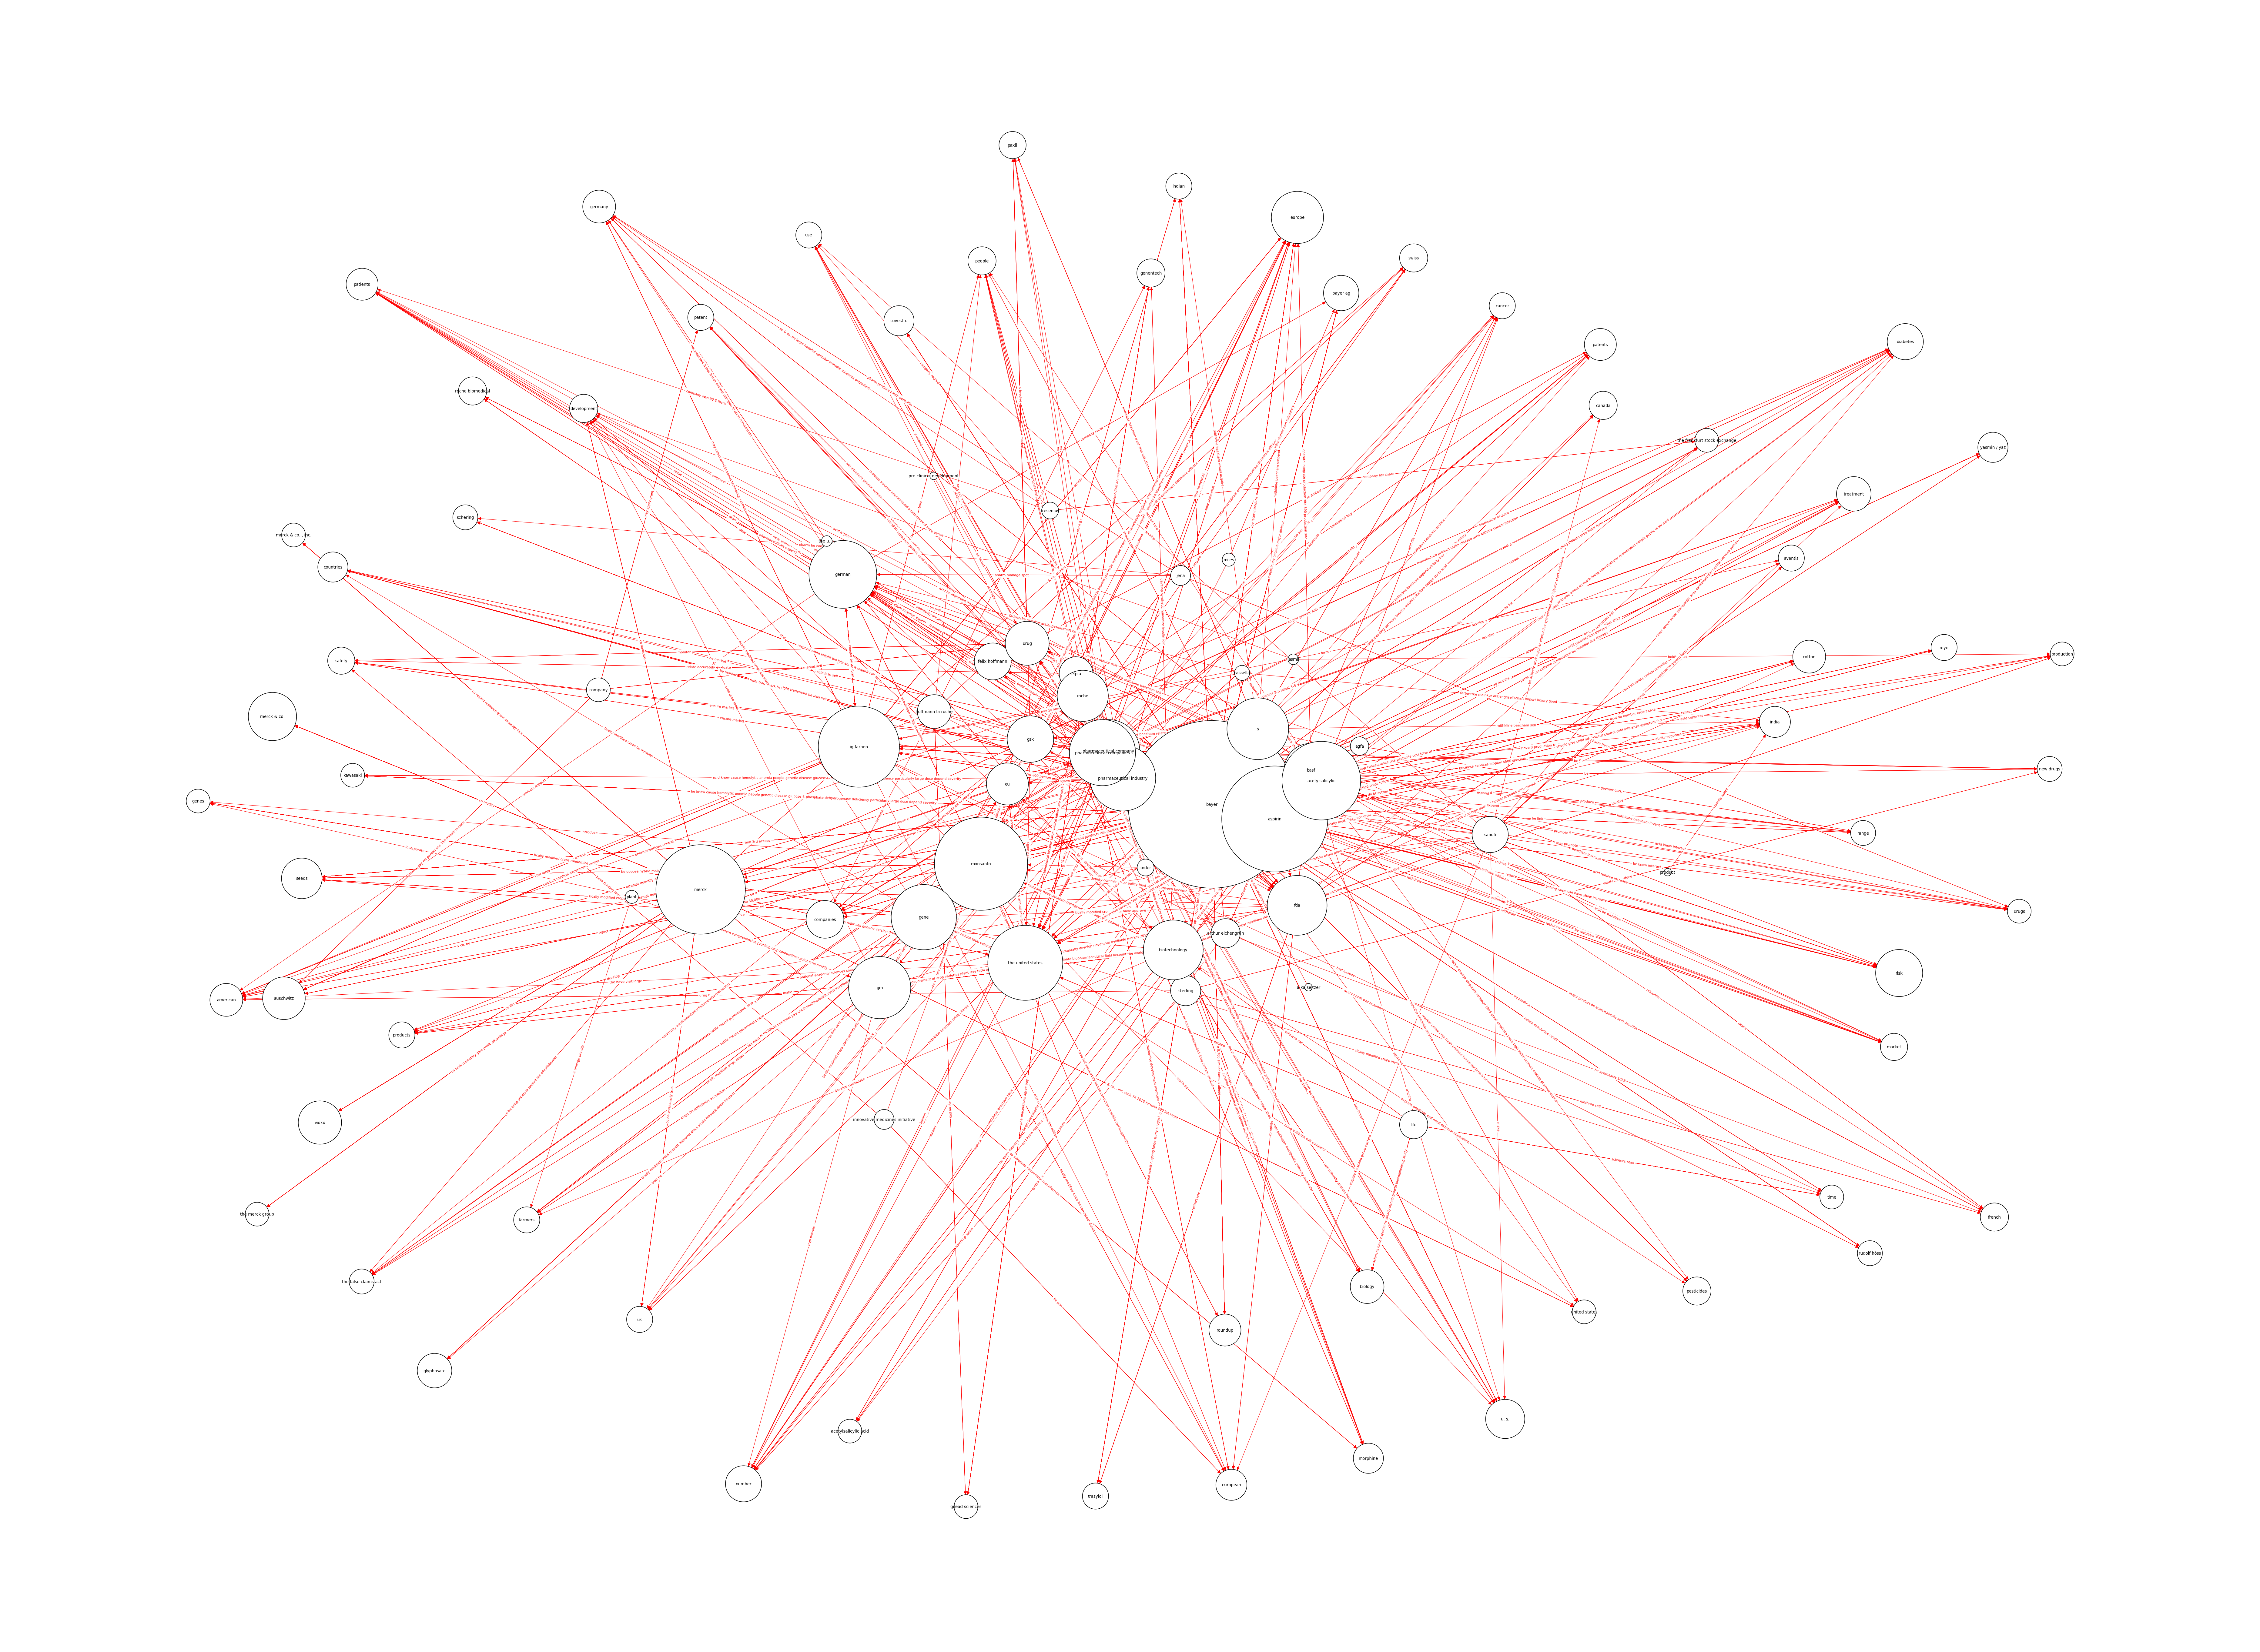

In [20]:
draw_kg(wiki_triplets, save_fig=True)

## Visualize KG subgraphs around specific topics


S-R-O:
 bayer - limit bleeding coronary bypass surgery cite flaw design study lead - canada

S-R-O:
 bayer - formally spin - covestro

S-R-O:
 bayer - build maintain - german

S-R-O:
 bayer - be divide evenly - companies

S-R-O:
 bayer - respond white knight bid july acquire majority share - schering

S-R-O:
 bayer - cropscience become major division - bayer ag

S-R-O:
 bayer - discover scientist - ig farben

S-R-O:
 bayer - help - felix hoffmann

S-R-O:
 bayer - buy - merck

S-R-O:
 german - conglomerate form - ig farben

S-R-O:
 german - company know - bayer ag

S-R-O:
 companies - include - bayer

S-R-O:
 ig farben - be - german

S-R-O:
 ig farben - ask rm 200 person - bayer

S-R-O:
 felix hoffmann - claim inventor aspirin    footnote - german

S-R-O:
 felix hoffmann - synthesize acetylsalicylic acid    work - bayer


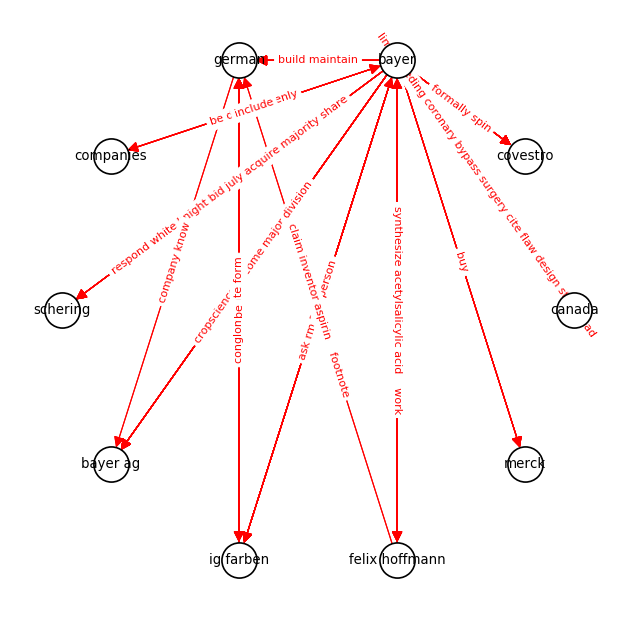

In [24]:
draw_kg_subgraph(wiki_triplets, 'bayer', n_hops=2, verbose=True, save_fig=True)


S-R-O:
 gm - crops be sufficiently accessible - farmers

S-R-O:
 gm - crop grow today - development

S-R-O:
 biotechnology - focus understand metabolic pathway relate disease state pathogen manipulate pathway molecular - biology

S-R-O:
 biotechnology - make - products

S-R-O:
 biotechnology - involve - production

S-R-O:
 biotechnology - focus - development

S-R-O:
 biotechnology - use naturally present bacteria - u. s.

S-R-O:
 biotechnology - enhance - seeds

S-R-O:
 biotechnology - express pesticide end need external application - pesticides

S-R-O:
 biotechnology - develop synthetic humanize insulin join - genentech

S-R-O:
 biotechnology - develop coordinate - farmers

S-R-O:
 biotechnology - learn - gm

S-R-O:
 biotechnology - associate - use

S-R-O:
 pharmaceutical industry - understand metabolic pathway relate disease state pathogen manipulate pathway molecular - biology

S-R-O:
 pharmaceutical industry - investigate - use

S-R-O:
 pharmaceutical industry - be develop - u. s.

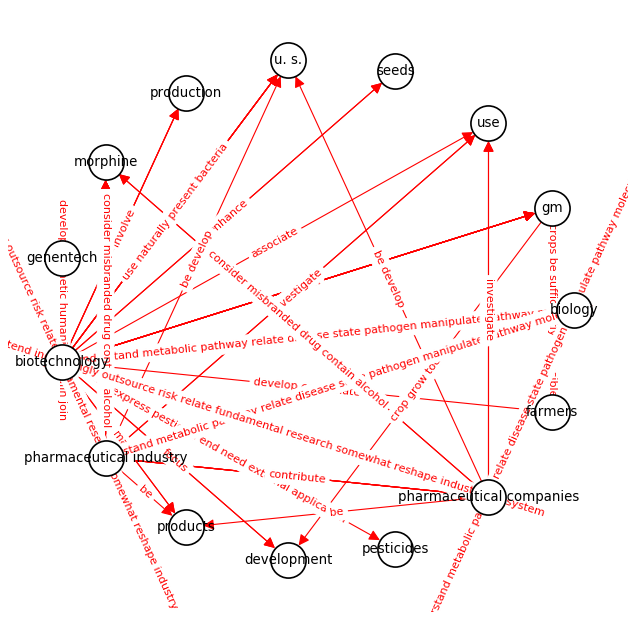

In [34]:
draw_kg_subgraph(wiki_triplets, 'pharmaceutical industry', n_hops=2, verbose=True, save_fig=True)


S-R-O:
 bayer - limit bleeding coronary bypass surgery cite flaw design study lead - canada

S-R-O:
 bayer - formally spin - covestro

S-R-O:
 bayer - build maintain - german

S-R-O:
 bayer - advertise - treatment

S-R-O:
 bayer - be divide evenly - companies

S-R-O:
 bayer - respond white knight bid july acquire majority share - schering

S-R-O:
 bayer - begin investigate - acetylsalicylic acid

S-R-O:
 bayer - help - felix hoffmann

S-R-O:
 bayer - buy - merck

S-R-O:
 bayer - product correctly have year allow use - aspirin

S-R-O:
 bayer - belong raise - risk

S-R-O:
 bayer - right trademark be lose sell - countries

S-R-O:
 companies - include - bayer

S-R-O:
 felix hoffmann - claim inventor aspirin    footnote - german

S-R-O:
 felix hoffmann - synthesize acetylsalicylic acid    work - bayer

S-R-O:
 felix hoffmann - be responsible - aspirin

S-R-O:
 merck - co persist 3–5 initial 3–5 - treatment

S-R-O:
 aspirin - capital remain registered trademark - bayer

S-R-O:
 aspirin - kn

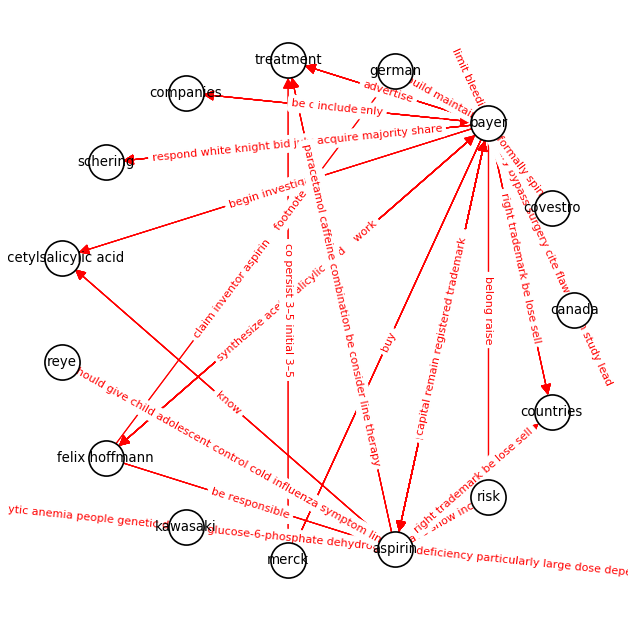

In [23]:
draw_kg_subgraph(wiki_triplets, 'aspirin', n_hops=2, verbose=True, save_fig=True)


S-R-O:
 bayer - limit bleeding coronary bypass surgery cite flaw design study lead - canada

S-R-O:
 bayer - list - indian

S-R-O:
 bayer - formally spin - covestro

S-R-O:
 bayer - face 8,700 similar lawsuit allege - roundup

S-R-O:
 bayer - build maintain - german

S-R-O:
 bayer - be divide evenly - companies

S-R-O:
 bayer - respond white knight bid july acquire majority share - schering

S-R-O:
 bayer - help - felix hoffmann

S-R-O:
 bayer - buy - merck

S-R-O:
 bayer - inherit lawsuit - monsanto

S-R-O:
 companies - include - bayer

S-R-O:
 felix hoffmann - claim inventor aspirin    footnote - german

S-R-O:
 felix hoffmann - synthesize acetylsalicylic acid    work - bayer

S-R-O:
 monsanto - brand products will market - bayer

S-R-O:
 monsanto - acquisition be big acquisition - german

S-R-O:
 monsanto - have fail adequately inform consumer possible carcinogenicity - roundup

S-R-O:
 monsanto - introduce - genes

S-R-O:
 monsanto - plant 87 - indian


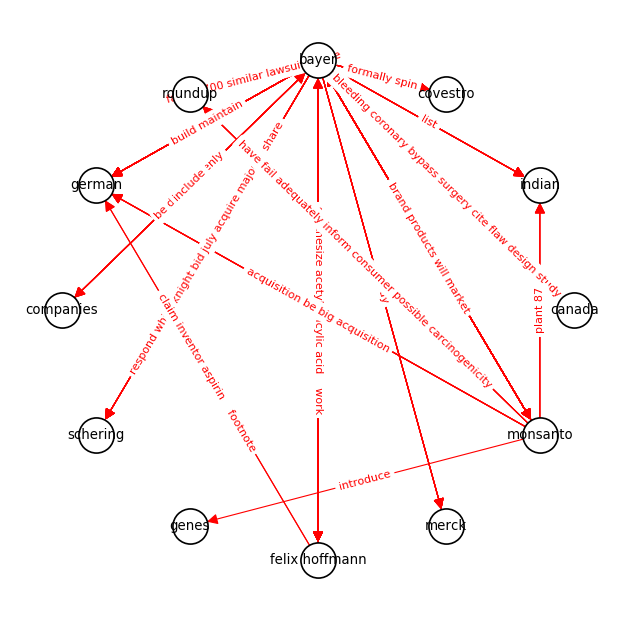

In [27]:
draw_kg_subgraph(wiki_triplets, 'monsanto', n_hops=2, verbose=True, save_fig=True)


S-R-O:
 gm - crops be sufficiently accessible - farmers

S-R-O:
 gm - crop grow today - development

S-R-O:
 basf - announce long term agreement cooperate research development marketing new plant - biotechnology

S-R-O:
 basf - reflect - production

S-R-O:
 basf - follow change corporate strategy 1965 great emphasis place high value product coating pharmaceutical - pesticides

S-R-O:
 basf - acquire - u. s.

S-R-O:
 biotechnology - focus understand metabolic pathway relate disease state pathogen manipulate pathway molecular - biology

S-R-O:
 biotechnology - make - products

S-R-O:
 biotechnology - involve - production

S-R-O:
 biotechnology - focus - development

S-R-O:
 biotechnology - use naturally present bacteria - u. s.

S-R-O:
 biotechnology - enhance - seeds

S-R-O:
 biotechnology - express pesticide end need external application - pesticides

S-R-O:
 biotechnology - develop synthetic humanize insulin join - genentech

S-R-O:
 biotechnology - develop coordinate - farmers

S-R-

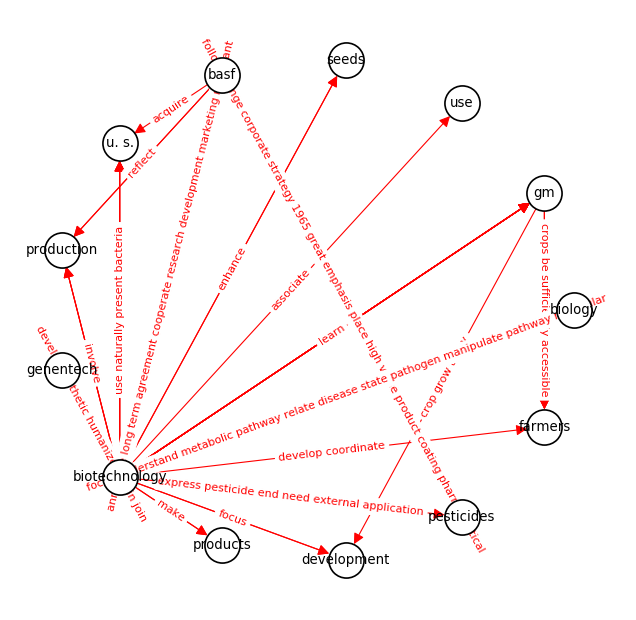

In [30]:
draw_kg_subgraph(wiki_triplets, 'basf', n_hops=2, verbose=True, save_fig=True)


S-R-O:
 basf - follow - german

S-R-O:
 basf - operate integrate production site 390 production site - europe

S-R-O:
 basf - dissolve - ig farben

S-R-O:
 basf - complete - european

S-R-O:
 basf - acquire - u. s.

S-R-O:
 german - conglomerate form - ig farben

S-R-O:
 ig farben - conduct medical experiment inmate - auschwitz

S-R-O:
 ig farben - occupy - europe

S-R-O:
 ig farben - be - german

S-R-O:
 ig farben - burn - people

S-R-O:
 ig farben - trial commit genocide million - european

S-R-O:
 ig farben - trial hold - u. s.

S-R-O:
 ig farben - trial include - time

S-R-O:
 ig farben - reestablish - basf


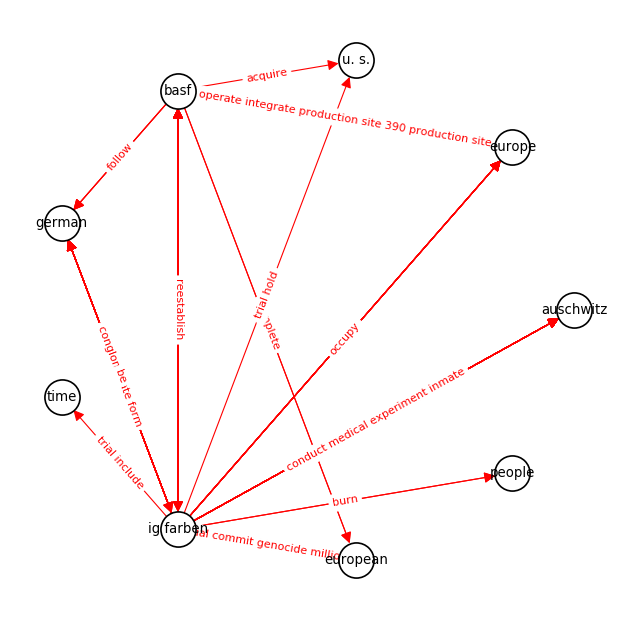

In [32]:
draw_kg_subgraph(wiki_triplets, 'ig farben', n_hops=1, verbose=True, save_fig=True)